<tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/220px-MnistExamples.png" alt="Drawing" style="width: 150px;"/> </td>
<td> <img src="https://miro.medium.com/max/3220/1*EoktyGnUpOv9Zq-85AIDZw.png" alt="Drawing" style="width: 150px;"/> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Pytorch_logo.png/800px-Pytorch_logo.png" alt="Drawing" style="width: 150px;"/> </td>
<td> <img src="https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png" alt="Drawing" style="width: 150px;"/> </td>
</tr>

# MNIST 99.5% From Scratch (fastai/PyTorch/ResNet)
by [@marketneutral](https://www.kaggle.com/marketneutral)

**YAMN**? Yet another MNIST notebook? There are probably a gazillion notebooks that go through MNIST and CNN fitting. Why another one? I have several reasons for creating this notebook including:

- lots of kernels show code but **don't explain** what's going on or how to set certain hyperparameters. This kernel does nothing without fully explaining what's going on. Where possible, I correlate choices I make back the **fastai lectures with timestamps**.
- I've never seen an application of **"human in the loop" machine learning** on Kaggle. Spoiler alert: this notebook is an example. See down below.
- Lastly, these are just **my personal notes** as I learn computer vision applications.


In [ ]:
import datetime
import imageio
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from fastai.vision import *
from fastai.metrics import accuracy, error_rate
from fastai.widgets import DatasetFormatter, PredictionsCorrector

In [ ]:
import fastai
print(fastai.__version__)

In [ ]:
np.random.seed(42)

# Load the Data

In [ ]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [ ]:
train.head()

Note that the data is in a strange format. Even though these are images, they have been **flatted out into rows**. Each row is an image and each column is a pixel value of the image. An image is **28x28 pixel gray-scale image flattend out to a single row of the pixel values (from 0 to 255)**.

## Convert single channel grayscale images to 3-channel RGB
The fastai library seems to be set up to handle **RGB images**. This means that every image is actually **three matrices**: one each for red, green, and blue values. One of the reasons, I think, this is the case is that fastai excels at **transfer learning** -- meaning the libary uses pre-trained models as a starting point. Pre-trained models, like **`resnet18`** (described below) have been trained on three channel images. A grayscale image is a single channel though. However a grayscale image can be represented as an RGB image where all three matrices have the same value. Let's confirm.

In [ ]:
y = train["label"].values
X = train.iloc[:, 1:].values

X.shape, y.shape

In [ ]:
# Pull out one image

img = X.reshape(-1, 28 ,28)[10,:]

# Now lets just repeat the same matrix three times

stacked_img = np.stack((img,)*3, axis=-1)
img.shape, stacked_img.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

ax[0].matshow(img, cmap='gray', alpha=1.0)
ax[0].set_title('Single Channel 28x28 Image Values')
ax[0].set_xticks(())
ax[0].set_yticks(())

for i in range(28):
    for j in range(28):
        c = img[j,i]
        ax[0].text(i, j, str(c), va='center', ha='center', fontsize=6, color='red')

ax[1].matshow(img, cmap='gray')
ax[1].set_title('Single Channel 28x28 Image');
ax[1].set_xticks(())
ax[1].set_yticks(());

In [ ]:
channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(stacked_img[:,:,i], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])

ax[3].imshow(stacked_img, cmap='gray')
ax[3].set_title('Three Channel Image')
ax[3].set_xticks([])
ax[3].set_yticks([]);

## Make the train/validation split

As usual, we split out a (single) validation set. I chose to stratify so that we have the same proportion of classes in the validation set. Note I set the random seed above. 

In [ ]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

## Write out data to the file system

We will need some helper functions to process all the data. We ultimately need to get our data into a `fastai.vision.ImageDataBunch`. It turns out that the easiest way to do that is to write out all the images to files and then point fastai to those files. This seems a little silly since the data are small and fit in memory, but it makes things a lot simpler. The first helper function, `to_img_shape`, takes the data matrix provided (which is of dimensions N images by 784 pixels and converts it to three channel **(N, x pixel, y pixel, channel) shape**. The second function, `save_imgs`, writes out the data to files. The folder stucture follows the "ImageNet folder structure" like

```
train/
   0/
   1/
   2/
   : 
   : 
   9/
valid/
   0/
   1/
   2/
   : 
   : 
   9/
test/
   testimg_00000.jpg
   testimg_00001.jpg
     : 
     : 
   testimg_27999.jpg
```

In [ ]:
def to_img_shape(X, y=[]):
    "Format matrix of rows, Nx784 to Nx28x28x3"
    X = np.array(X).reshape(-1,28,28)
    X = np.stack((X,)*3, axis=-1)
    y = np.array(y)
    return X, y

def save_imgs(path:Path, data, labels=[]):
    """Save numpy formated images to files. We have to be careful with the filenames.
    If you just name the files like 0.jpg, 1.jpg, 2.jpg, etc. then the sort order will
    be off. The sort order for strings is like strings sort like 0, 1, 10, 2... Therefore
    we pad the integer with leading zeros like "00001.jpg".
    """
    
    path.mkdir(parents=True, exist_ok=True)
    
    for label in np.unique(labels):
        (path / str(label)).mkdir(parents=True, exist_ok=True)

    for i in range(len(data)):
        if(len(labels) != 0):
            imageio.imsave(str(path / str(labels[i]) / (str(i) + '.jpg')), data[i])
        else:  # this must be test data; order matters!!
            imageio.imsave(str(path / f'testimg_{str(i).zfill(5)}.jpg'), data[i])

In [ ]:
X_train, y_train = to_img_shape(X_train, y_train)
X_valid, y_valid = to_img_shape(X_valid, y_valid)
X_test, _ = to_img_shape(test)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape

In [ ]:
%%time
save_imgs(Path('/kaggle/working/data/train'), X_train, y_train)

In [ ]:
%%time
save_imgs(Path('/kaggle/working/data/valid'), X_valid, y_valid)

In [ ]:
%%time
save_imgs(Path('/kaggle/working/data/test'), X_test)

# Create the fastai `ImageDataBunch`

## ...Sidebar on Data Augmentation...
`fastai` also ships with out-of-the box data augmentation. The idea is that there are many kinds of slight variations in images which you would expect to see, but which don't actually exist in the data. We can therefore create synthetic data by making slight modifications of training samples in very specific ways. It's best to show this by example. `fastai` has a function `get_transforms()` which returns a **preset list of common transforms that work well on many image types**:

In [ ]:
path = Path('/kaggle/working/data')
image_list = (ImageList.from_folder(path)
                       .split_by_folder()
                       .label_from_folder())

data = (image_list.databunch(bs=1)
                  .normalize(imagenet_stats))

In [ ]:
tfms = get_transforms()
tfms[0]  # The zero lists the transforms applied during training

In [ ]:
tfms[1]  # These are the transforms which are applied during validation

The are 7 transforms. **Let's try them out on a single image.**

In [ ]:
# The images are not guaranteed to be in a particular order!
for idx in range(len(data.train_ds.x)):
    label = int(str(data.train_ds.y[idx])) == 5
    if label:
        break
        
def get_ex(i):
    return data.train_ds.x[i]

def plots_f(tfms, rows, cols, width, height, **kwargs):
    np.random.seed(17)
    j = idx
    # Code from the fastai docs https://docs.fast.ai/vision.transform.html
    [get_ex(j).apply_tfms(tfms[0], **kwargs).show(ax=ax)
        for i, ax in enumerate(plt.subplots(rows, cols, figsize=(width,height))[1].flatten())]

In [ ]:
plots_f(tfms, 2, 4, 12, 6)

The images above are **randomly generated from a single real training image**. There are slight changes in rotation, zoom, contrast, etc. There's also a problem...we've randomly **flipped images**. That might make sense in some circumstances, but doesn't make sense for numbers or letters. As such, let's remove the flipping behavior; also we increase the rotation to accentuate that.

In [ ]:
tfms = get_transforms(do_flip=False)
tfms[0]

In [ ]:
plots_f(tfms, 2, 4, 12, 6, padding_mode='zeros') 

We take our existing `image_list` and append the transforms. Note this does **not** apply the transforms; it merely registers them as valid transforms to apply when a learner asks for a batch. We recreate the data bynch object again with the transforms attached.

In [ ]:
image_list = (image_list.transform(get_transforms(do_flip=False), size=28)
                        .add_test(ItemList.from_folder(path=path/"test"), label=None))

data = (image_list.databunch(bs=256)
                  .normalize(imagenet_stats))

For reference, the complete code is

```python
data = (ImageList.from_folder(path)
                 .split_by_folder()
                 .label_from_folder()
                 .transform(get_transforms(do_flip=False), size=28)
                 .add_test(ItemList.from_folder(path=path/"test"), label=None)
                 .databunch(bs=256)
                 .normalize(imagenet_stats))
```

We can inspect the `ImageDataBunch` as

In [ ]:
data

and also plot some of the training images

In [ ]:
data.show_batch(3, figsize=(7,7))

# The fast.ai way

Here it is!

In [ ]:
from graphviz import Source
src = Source('''
    digraph {
        rankdir=LR
        node [shape=box style=rounded]
        "make ImageDataBunch" -> "make pretrained cnn_learner"->"lr_find"->"fit head for a few cycles"->"unfreeze"->"lr_find"->"fit full model"->"get Kaggle 🥇"
    }
''')
src

We make a `cnn_learner` which is based on a **pre-trained PyTorch** model. We then use the **learning rate finder** to find the optimal maximum learning rate to apply. `fastai` takes the pretrained model and adds a head (described below). Initially we **fit just the head**, leaving the pre-trained model fixed (or "frozen"). We can get pretty good results already, but to get even better we **unfreeze the pre-trained model** and fit it with a **much smaller learning rate**.

We create the learner. This will download a pre-trained `PyTorch` model from it's hub. We pass in our `ImageDataBunch` and register accuracy as the metric we care about. Note that the accuracy is just a printed metric; **it does not affect fitting**. The default loss function for the a `cnn_learner` is cross entropy -- the loss function for a multi-class classification problem (which this is).

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [ ]:
learn.model

Here we run the **learning rate finder**. Per Jeremy ("Jeremy says..."), lesson 3: 49:00, "do lr_find, lr_plot and find the learning rate with the steepest slope, **not the bottom!**"

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()
plt.axvline(0.020, c='r', linestyle='--');

I pick `0.02` as my maximum learning rate as it's "in the middle of the steepest slope", and then I fit several cycles.

In [ ]:
learn.fit_one_cycle(5, 0.02)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

Now we **unfreeze** the pretrained layers and look for a learning rate slice to apply. In Lesson 3 49:20: "Call \[lr_find\] again...Look to **just before it shoots up**1e-4) and go **back 10x**, which is 1e-5, and that's what I do for the first half of my slice; and for the second half of my slice, I normally **use whatever learning rate I used for the first part divided by 5 or 10.**"

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.recorder.plot()

And now we fit for a long time. Why? I tried a few values for the number of epochs. Per Jeremy, training loss should be **less than validation loss** or else you are **underfitting**. Lesson 3: 1:25:12: "when you do plot_losses and see you the training loss go down, then go up a little for a bit, then go down a lot you've found a really good maximum learning rate." Generally want to keep fitting as long as training loss is going down **and** validation loss is not going up. 

![](https://hackernoon.com/hn-images/1*vuZxFMi5fODz2OEcpG-S1g.png)

In [ ]:
%%time
learn.fit_one_cycle(35, max_lr=slice(1e-5, 0.02/10))

In [ ]:
learn.save('stage-2')

Our plot of train and validation loss looks good.

In [ ]:
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

We can see from the confusion matrix that we make very very few errors on the validation set.

In [ ]:
interp.plot_confusion_matrix()

The errors that we do make seem like errors even a human would make.

In [ ]:
interp.plot_top_losses(9, figsize=(7,7))

Now we are ready to submit to Kaggle. Here is a helper function that makes the prediction on the test set and saves the submission file.

In [ ]:
def make_submission_file(
    learner,
    filename=f'submission_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv',
    preds=None
):
    """Takes a trained fastai learner (and optional pre-computed list of predicted
    labels) and makes a Kaggle submisison file. This is tricky because the learner
    returns the order of the test set as `os.listdir` does. This is *not* in the
    order they were created!
    """
    
    if preds is None:
        preds, _ = learner.get_preds(ds_type=DatasetType.Test)
        preds = np.argmax(preds, 1)

    test_index = []
    num = len(learn.data.test_ds)
    for i in range(num):
        test_index.append(str(learner.data.test_ds.items[i]).split('/')[-1])
    
    df = (pd.DataFrame(data={"Label": preds, "Filename": test_index})
            .sort_values(by='Filename')
            .drop('Filename', axis=1)
            .assign(ImageId = range(1, len(preds) + 1))
            .reset_index(drop=True)
            .reindex(columns=['ImageId', 'Label']))

    df.to_csv(filename, index=False)
    print(f'Saved predictions as {filename}.')

This submission gets **0.99442** on the public leaderboard.

In [ ]:
make_submission_file(learn, filename="resnet18-fine-tuned.csv")

# How Does the Pre-Trained Model Work???

How does the pre-trained model use **our image size**? The PyTorch `resnet18` model was trained on ImageNet images. These images are 3-channel 224x224 pixels. Our images are 3-channel 28x28. How can we use pre-trained weights for a model trained on different images sizes? This took me a while to grok, so I am making a special call-out box on it. Let's look at the first layers of the model instantiated as `learn`:

```
  Path: /kaggle/working/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      :
      :
      :
```

The first layer is a 2d convolution. What is a convolution doing? The convolution slides a 7x7 matrix across each input channel of your image and does element-by-element multiplication summed against what it sees (this is sometimes described as matrix multiplication--wrong--or a dot prodcut. The dot product of the stretched out kernel (7x7=49 in this case) and the image segment is the same as element-by-element multuplcation summed). In this model, there are 64 kernels that slide across each channel. A key idea is that the elements of these 7x7 matrices are **learned weights**. The **sizes of the kernels** are fixed even though the image sizes are not. This means that the count of weights does not vary at all as a function of image size. This also makes clear why we needed to convert our one channel images to three channels: pre-trained `resnet18` requires 3 input channels; these **kernels are the weights**. In addition to convolutional layers, the model has `ReLU` layers too. However there are no weights here; this layer is just making some non-linearity of what the prior convolutional layer outputs. So how many weights are there in the first convolutional layer? 7 x 7 x 3 channels x 64 = 9408. At some point though, this logic breaks. At the end of the model, we take the last convolutional layer, connect it to a "fully-connected" layer and output to a certain number of classes. There are two things to understand about this. First let's look at the **actually pre-trained model from the PyTorch website** (**not** our `learn` instance):

```
    :
    :
    :
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=1000, bias=True)
)
```

The last convolutional block feeds into an `AdaptiveAvgPool2d(...)` layer which feeds into a fully-connected layer with 1000 outputs. These 1000 outputs are the ImageNet classes. Without going into [details](https://pytorch.org/docs/stable/nn.html#torch.nn.AdaptiveAvgPool2d), the key idea of the `AdaptiveAvgPool2d` layer is that it takes **any input size** and always outputs the same size. This is how we can use any input image size passing through the convolutional layers and make it fit a pre-defined fully-connected layer. However this last layer -- this is where our idea breaks down: we don't have 1000 classes, we have 10. To see how fastai deals with this, let's look not at the model from the PyTorch website, but the actual model instantiated as `learn`. When we look at the last layers of this model we see:

```
     :
     :
     :
     (1): BasicBlock(
        (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
  ```
  
  Complex! fastai cut off the `avgpool` and the `fc` layers from the pre-trained model and then added a bunch of it's own layers. **These added layers are the only ones trained when you first call `fit_one_cycle`**. Notice that `out_features=10`; fastai made this layer for us based on the number of classes in our data. And that's it. 

<div class="alert alert-info">
In summary: 1) convolutional layers are defined by their kernel sizes (weights) and can handle variable images sized; 2) ReLu doesn't care about input/output size; 3) adaptive pooling takes any input size and, with a constant kernel size, always outputs the same size; this is the key to connect variable image sizes to a pre-defined fully-connected layer size; 4) fastai cuts off the last layer of the pre-trained model, and adds a layer that matches the number of classes in our data.
</div>

### Where is the addition step?

The famous "ResNet block" above is the `BasicBlock`. We can simply see the names of the components (Conv2d, BatchNorm2d, ReLU) and the order and that they match the [architecture diagram](http://torch.ch/blog/2016/02/04/resnets.html)

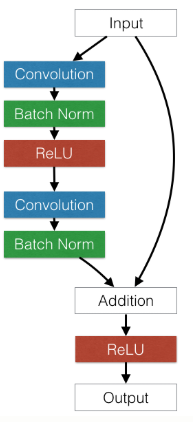

Notice that the stride is `1`, kernel size is `3x3`, and (zero)padding is `1`. As discussed in [this great post](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/), if you have a stride of 1 and set padding equal to (K-1)/2, **then the output size will be the same as the input size**. So, again, we are robust to whatever image size you want (image size, not number of channels; we must have 3 and only 3 channels) -- the network just continues to pass your size through. **But where is the addition step?** If you look at the [`pytorch` source code for `BasicBlock()`](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L35) you will see it! It's very simple... the forward pass through the block is
```python
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
```        

At start start of the `BasicBlock` we store the input as `identity` and at the end we add it back with `out += identity`.

# Human in the Loop AI

The idea of uncertainty and "trustworthiness" in AI is a big deal in industry. In order to combat **[algorithm aversion](https://hbr.org/2015/02/heres-why-people-trust-human-judgment-over-algorithms)** and deploy production systems in high risk domains like medicine, researchers often insert a "human in the loop". This is best explained in the following diagram.

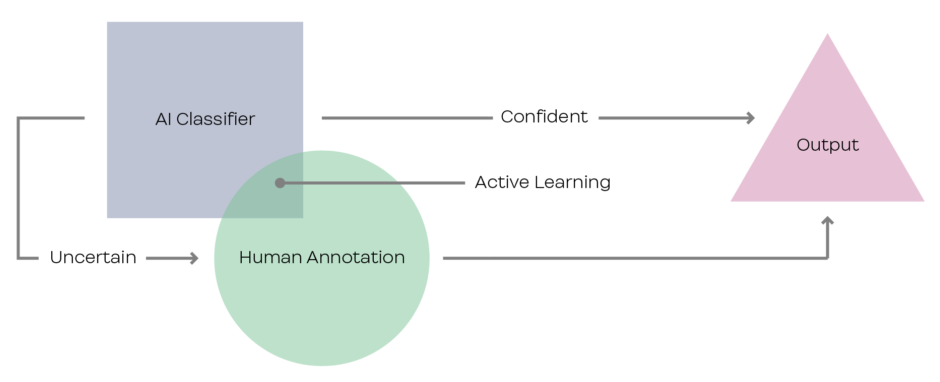

*Image source: https://www.figure-eight.com/resources/human-in-the-loop/*

We trust our classifier...unless it tells us that it is not very confident! In that case, we raise the case to a human arbiter. It turns out that **`fastai` supports human in the loop AI out-of-the box!** Amazing! There are lots of complicated ways to get a classifier to tell you if it is confident or not. For example, one way is to employ **"monte carlo dropout" in the inference stage**. In this way, we make many predictions all the while randomly turning off some neurons. We get many predictions and then we cacluate the entropy of the prediction set. If the entropy is high (meaning the classifier gave us lots of different predictions while we were flipping neurons on and off), then we know that it isn't very confident as the classifer is not robust to that example. Another way is to make a **fully Bayesian neural network**: we model the weights as random variables and thus we get a posterior distribution for the weights **and** the predicted classes. Both of those are very very complex. In usual `fastai` brilliance, the library does something simple, intuitive, and elegant: for each prediction, it looks at the gap between the actual preduction (`np.argmax(pred[i, :], 1))` as usual) and the **second best prediction**. 

A low difference means the classifier is unsure. There is a Jupyter widget, **[`PredictionsCorrector`](https://docs.fast.ai/widgets.image_cleaner.html#PredictionsCorrector)** which then serves up **batches of the most unsure predictions for the human analyst (you!) to confirm**. It looks like this:

<img src="https://docs.fast.ai/imgs/PredictionsCorrector.gif">

*Image source: fastai docs, https://docs.fast.ai/widgets.image_cleaner.html*

This kind of "post prediction human supervision" is of course not appropriate in all cases. Sometimes classifiers operate at super-human level. For example. one student project highlighted in the 2018 course was classifying satellite images to one of over 100 countries. In this case, it's unlikely that a human could be of assistance. However, **MNIST** is a perfect use case. We already have 99.5% accuracy on 28,000 labels. We are wrong on only approximately 140(!) in a domain where humans excel.

You are (likely) viewing the commited and published version of this kernel. In that case, you cannot interact with the `PredictionsCorrector`. That class runs on top of `ipywidgets` which needs a live Python kernel behind it (note when you see other Kaggle kernels with interactive plots, you are interacting with Javascript, not Python).

I ran the `PredictionsCorrector` with

```python
most_unsure = DatasetFormatter.from_most_unsure(learn)
wgt = PredictionsCorrector(*most_unsure)
```

and made manual corrections on X labels. The manual corrections can be seen with

```python
wgt.show_corrections(ncols=6, figsize=(9, 7))
```

**If you want to do corrections yourself in this kernel, you have to fork it and run it from the top to this point.**

In [ ]:
most_unsure = DatasetFormatter.from_most_unsure(learn)

In [ ]:
# wgt = PredictionsCorrector(*most_unsure)

In [ ]:
# wgt.show_corrections(ncols=6, figsize=(12, 7))

I "corrected" 19 images. The actual changes were

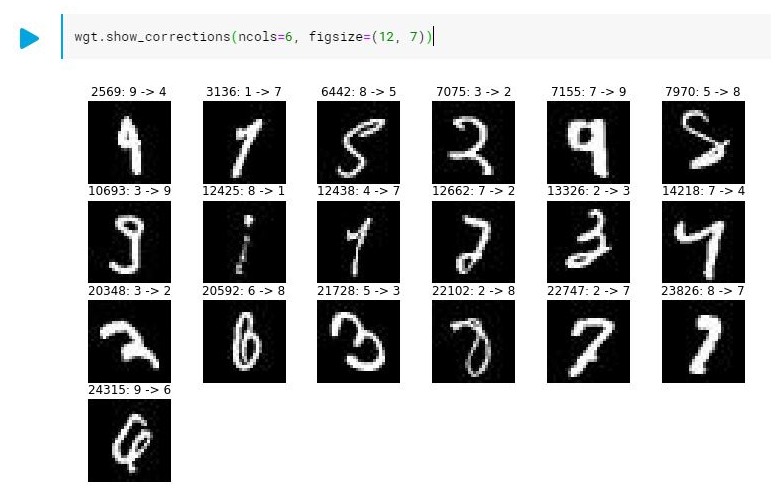

This corrected solution improves the final leaderboard score to **0.99571** (47 places improved as of the publication of this kernel). **The error rate is improved by 23% from the human-in-the-loop step.**

In [ ]:
err1 = 1 - 0.99442
err2 = 1 - 0.99571
print(f'Human in the loop improvement: {100*(err1-err2)/err1}%')

In order to get the corrected labels to persist with this commited kernel I cached it in an external file store (I used an Amazon S3 bucket), and here I reload it. This allows the kernel to be able to use the submission file with the corrected labels after hitting "Commit".

In [ ]:
%%capture
# I have to fetch the hand corrected labels
!wget https://kaggle-himl-mnist.s3.amazonaws.com/resnet18-hitlml-corrected.csv

# Clean Up

The commited kernel has a maximum output file count of 500, so we need to delete all the images we cached to the file system.

In [ ]:
!rm -rf /kaggle/working/data/train
!rm -rf /kaggle/working/data/test
!rm -rf /kaggle/working/data/valid